In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import time
import os
import cv2
import datetime
import tensorflow as tf
import random as rd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [64]:
train_x = None
train_y = None
n_sample = 0

In [2]:
swipe_x1, swipe_y1, swipe_x2, swipe_y2 = 320, 1000, 320, 1000
mistrust = 1

In [41]:
def get_img():
    os.system('adb shell screencap -p /sdcard/1.png')
    os.system('adb pull /sdcard/1.png .')
    img = cv2.imread('1.png')
    img = img[::7,::7,1].reshape(1,183,103,1)
    return img

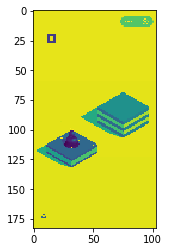

(183, 103, 1)
(183, 103)


In [42]:
img = get_img()
im = plt.imshow(img.reshape(183,103))
plt.show()
input_shape = img.shape[1:]
img_dim = img.shape[1:3]
print(input_shape)
print(img_dim)

In [43]:
img

array([[[[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        ..., 
        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]]]], dtype=uint8)

In [44]:
np.amax(img[:50,:50])

255

In [60]:
def jump(press_time):
    cmd = 'adb shell input swipe {} {} {} {} {}'.format(swipe_x1, swipe_y1, swipe_x2, swipe_y2, math.ceil(max(press_time,200)))
    os.system(cmd)
    print(press_time)

In [46]:
def success(img_new,img):
    if np.amax(np.absolute(img_new.reshape(img_dim)[:25,:25]-img.reshape(img_dim)[:25,:25]))>50:
        return True
    else:
        return False

In [47]:
def fail(img_new):
    if np.amax(img_new.reshape(img_dim)[:25,:25])>50:
        return False
    else:
        return True

In [10]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta())

In [31]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

In [48]:
def network(model,img,confidence):
    if rd.uniform(0,1)<confidence:
        return model.predict(img)
    else:
        return np.array(rd.randint(40,90)).reshape(1,1)

In [12]:
np.array(rd.randint(20,120)).reshape(1,1)[0][0]

69

In [49]:
mistrust = 1

In [14]:
def train(model,img,press_time):
    model.fit(img,np.array([press_time]).reshape(1,1),1)

In [76]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [90]:
def test():
    img = get_img()
    while(True):
        press_time = network(model,img,1)[0][0]
        jump(press_time*10)
        time.sleep(2.3+press_time/200)
        img_new = get_img()
        if fail(img_new):
            jump(2)
            time.sleep(0.8)
            img_new = get_img()
        img = img_new

In [84]:
img = get_img()
while(True):
    mistrust = mistrust*0.99
    press_time = network(model,img,1-mistrust)[0][0]
    jump(press_time*10)
    time.sleep(2.3+press_time/200)
    img_new = get_img()
    if fail(img_new):
        jump(2)
        time.sleep(0.8)
        img_new = get_img()
    elif success(img_new,img):
        if n_sample == 0:
            train_x = img
            train_y = press_time.reshape(1,1)
        else:
            train_x = np.concatenate((train_x,img),axis=0)
            train_y = np.concatenate((train_y,press_time.reshape(1,1)),axis=0)
        n_sample+=1
        if n_sample%128==0:
            mistrust = rd.uniform(0,1)
            print(mistrust)
            model.fit(train_x,train_y)
            np.save('train_x',train_x)
            np.save('train_y',train_y)
    img = img_new

543.932914734
572.351722717
570
660
2
618.149032593
762.693862915
670
2


TypeError: 'NoneType' object is not subscriptable

In [33]:
while(True):
    train(model,img,70)
    print(network(model,img,1))

Epoch 1/1
1/1 [==============================] - 0s 83ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4652.7266
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4900.0000
[[ 42.95502472]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4900.0000
[[ 84.20837402]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1703.4292
[[ 82.27296448]]
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6936.6968
[[ 44.29628754]]
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 4900.0000
[[ 16.30095673]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 99.2701
[[ 4.54102993]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 838.1266


[[ 55.77524185]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 122.2159
[[ 55.91777802]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 9.0043
[[ 56.2035675]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2.2877
[[ 56.57242966]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.6736
[[ 56.84421921]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 227.1259
[[ 57.68836594]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 178.9497
[[ 58.81879425]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 210.2518
[[ 59.05179977]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 428.9409
[[ 60.0333786]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8557
[[ 60.954216]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 180.9769
[[ 60.90051651]]
Epoch 1/1
1/1 [==============================

[[ 91.11585999]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 159.9081
[[ 90.36210632]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 3697.2656
[[ 83.80457306]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 415.1817
[[ 76.86546326]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 647.2256
[[ 69.30181885]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 155.7297
[[ 62.29963303]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 129.1864
[[ 56.12612152]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 9.5100
[[ 50.99726105]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1404.9729
[[ 47.64123154]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 182.8706
[[ 45.19827652]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1219.9688
[[ 44.03242493]]
Epoch 1/1
1/1 [=================

[[ 46.54044724]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 331.9078
[[ 45.42181015]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 759.0979
[[ 45.49934387]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1778.8126
[[ 46.46931839]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 143.4612
[[ 47.8792305]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 84.0903
[[ 49.50481796]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 29.4733
[[ 51.24308014]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 222.0245
[[ 53.37713623]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1699.6838
[[ 56.5069313]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 725.4031
[[ 60.55806732]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 40.2678
[[ 63.86751938]]
Epoch 1/1
1/1 [=====================

[[ 57.01533127]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 39.2441
[[ 58.50535202]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 148.3686
[[ 60.91508102]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 163.2032
[[ 64.24649048]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1038.2283
[[ 68.6686554]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 42.5774
[[ 73.16466522]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 135.4187
[[ 78.23326111]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 77.3289
[[ 81.96627808]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1301.0829
[[ 80.36690521]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 345.8680
[[ 76.7049942]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 475.3017
[[ 70.80455017]]
Epoch 1/1
1/1 [=====================

1/1 [==============================] - 0s 3ms/step - loss: 4.3705
[[ 49.07348633]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2.1268
[[ 50.1389122]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 660.5197
[[ 52.2554512]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 367.4901
[[ 55.29154968]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 35.5471
[[ 57.66072464]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.5229
[[ 59.92738724]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 263.6041
[[ 63.02319336]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 157.8204
[[ 64.9118042]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 120.5018
[[ 67.29614258]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 239.1844
[[ 70.42090607]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1

1/1 [==============================] - 0s 3ms/step - loss: 129.1784
[[ 62.37025452]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 634.7738
[[ 64.42686462]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 197.2951
[[ 67.0075531]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 275.6447
[[ 70.42813873]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 349.2512
[[ 74.53035736]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 104.6180
[[ 77.56890106]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 105.1784
[[ 79.56702423]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 456.9867
[[ 82.23452759]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 594.7177
[[ 82.32379913]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1597.7328
[[ 83.83219147]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step

[[ 71.78836823]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4.9359e-04
[[ 74.6910553]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 684.9622
[[ 74.8290863]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 184.4241
[[ 73.76053619]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 271.2433
[[ 71.50643921]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 130.4089
[[ 70.18727112]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 257.6350
[[ 69.8939743]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2164.6355
[[ 70.74155426]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 448.4990
[[ 69.52178955]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 784.3929
[[ 69.73916626]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8265
[[ 69.8756485]]
Epoch 1/1
1/1 [=====================

[[ 59.92925262]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 260.3241
[[ 64.65616608]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 336.4305
[[ 69.92266846]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 19.6567
[[ 75.08899689]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 108.7485
[[ 80.54380798]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 108.8204
[[ 84.82552338]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1274.4440
[[ 85.24658203]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2443.3521
[[ 80.36746979]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 150.3788
[[ 75.24238586]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 13.7051
[[ 71.0069046]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 253.9144
[[ 66.14228821]]
Epoch 1/1
1/1 [===================

[[ 75.75680542]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1247.7493
[[ 69.17700195]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 11.2541
[[ 64.29136658]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 76.2776
[[ 60.55304718]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 594.6929
[[ 58.22688675]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1315.6250
[[ 57.54319763]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 623.1213
[[ 58.10484314]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 134.0381
[[ 59.22466278]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 339.8968
[[ 60.9433136]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 22.4036
[[ 62.74168777]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 138.4643
[[ 64.90341187]]
Epoch 1/1
1/1 [====================

[[ 58.44517899]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 472.3464
[[ 59.8399353]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 118.4912
[[ 61.64829254]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6460
[[ 63.34380341]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 575.6597
[[ 65.72827148]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 40.6947
[[ 67.53149414]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 18.6623
[[ 68.93934631]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 100.6529
[[ 70.75411987]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 238.3875
[[ 71.34802246]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 79.3329
[[ 72.3536911]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 148.3905
[[ 72.46937561]]
Epoch 1/1
1/1 [=========================

KeyboardInterrupt: 

In [17]:
model.save('my_model.h5')

In [ ]:
network(model,img,1-mistrust)

In [ ]:
jump(math.ceil(400.1123))

In [70]:
np.save('train_x',train_x)
np.save('train_y',train_y)

In [ ]:
train_x.shape

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 181, 101, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 25, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 23, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 5, 16)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 5, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25632     
__________

In [99]:
while True:
    model.fit(train_x,train_y,validation_split=0.2)

Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 1s 358us/step - loss: 710.2869 - val_loss: 141.7359
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 241us/step - loss: 342.1548 - val_loss: 106.4325
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 270.6826 - val_loss: 101.0679
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 245us/step - loss: 258.7419 - val_loss: 112.6773
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 244us/step - loss: 236.0895 - val_loss: 58.2856
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 226.8815 - val_loss: 55.2471
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==========

1567/1567 [==============================] - 0s 248us/step - loss: 160.2686 - val_loss: 81.6682
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 152.9585 - val_loss: 34.4970
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 277us/step - loss: 149.6350 - val_loss: 34.6382
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 267us/step - loss: 158.2753 - val_loss: 58.7117
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 165.1204 - val_loss: 39.6014
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 164.2447 - val_loss: 35.9767
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 273us/step - loss: 149.9279 - val_

Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 242us/step - loss: 141.0737 - val_loss: 33.1289
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 234us/step - loss: 141.0254 - val_loss: 59.7288
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 270us/step - loss: 145.2934 - val_loss: 33.7637
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 274us/step - loss: 130.6358 - val_loss: 34.3896
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 264us/step - loss: 141.3539 - val_loss: 49.2855
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 265us/step - loss: 128.3683 - val_loss: 34.8713
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============

1567/1567 [==============================] - 0s 238us/step - loss: 134.6599 - val_loss: 38.7017
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 126.4143 - val_loss: 39.3293
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 138.8613 - val_loss: 58.1029
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 131.8318 - val_loss: 34.0174
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 138.2569 - val_loss: 32.3891
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 244us/step - loss: 131.8388 - val_loss: 33.4209
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 243us/step - loss: 128.4259 - val_

Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 238us/step - loss: 129.0246 - val_loss: 31.1254
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 240us/step - loss: 131.3546 - val_loss: 32.4634
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 266us/step - loss: 128.6576 - val_loss: 34.8079
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 258us/step - loss: 117.0773 - val_loss: 32.2421
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 124.9735 - val_loss: 34.0556
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 119.1545 - val_loss: 32.2079
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============

1567/1567 [==============================] - 0s 238us/step - loss: 126.3740 - val_loss: 42.9683
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 120.5354 - val_loss: 32.8925
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 241us/step - loss: 121.3849 - val_loss: 35.7558
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 243us/step - loss: 118.3727 - val_loss: 37.0494
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 128.6037 - val_loss: 30.3185
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 122.5319 - val_loss: 36.6846
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 265us/step - loss: 118.4797 - val_

Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 113.4259 - val_loss: 40.8355
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 107.5077 - val_loss: 38.1785
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 110.1577 - val_loss: 31.2889
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 271us/step - loss: 107.2333 - val_loss: 30.6510
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 112.2267 - val_loss: 32.2844
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 115.8678 - val_loss: 30.8132
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============

1567/1567 [==============================] - 0s 238us/step - loss: 116.8027 - val_loss: 37.1206
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 109.6958 - val_loss: 30.1491
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 113.2136 - val_loss: 30.1650
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 102.4899 - val_loss: 30.6656
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 246us/step - loss: 117.2411 - val_loss: 29.6063
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 103.4902 - val_loss: 32.3198
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 109.7940 - val_

Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 242us/step - loss: 102.7744 - val_loss: 29.5924
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 240us/step - loss: 100.5551 - val_loss: 28.9837
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 280us/step - loss: 99.2602 - val_loss: 38.8860
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 274us/step - loss: 107.6895 - val_loss: 30.8015
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 261us/step - loss: 111.8917 - val_loss: 30.5124
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 256us/step - loss: 113.4961 - val_loss: 28.6181
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [===============

1567/1567 [==============================] - 0s 247us/step - loss: 98.5149 - val_loss: 30.9410
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 109.3001 - val_loss: 32.8012
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 255us/step - loss: 104.4363 - val_loss: 31.2892
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 264us/step - loss: 105.5873 - val_loss: 44.2480
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 101.8042 - val_loss: 33.6045
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 102.5563 - val_loss: 30.0125
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 245us/step - loss: 103.0512 - val_l

1567/1567 [==============================] - 0s 234us/step - loss: 95.1447 - val_loss: 30.2130
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 235us/step - loss: 100.4123 - val_loss: 50.0618
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 258us/step - loss: 89.8742 - val_loss: 31.0288
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 96.5142 - val_loss: 30.3509
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 95.2570 - val_loss: 34.2312
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 244us/step - loss: 98.8785 - val_loss: 47.9778
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 100.1902 - val_loss:

1567/1567 [==============================] - 0s 243us/step - loss: 96.5988 - val_loss: 31.1369
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 238us/step - loss: 84.3435 - val_loss: 31.4935
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 234us/step - loss: 95.9255 - val_loss: 31.2437
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 95.6668 - val_loss: 29.9263
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 266us/step - loss: 99.2290 - val_loss: 42.4306
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 89.4632 - val_loss: 30.1631
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 234us/step - loss: 88.7301 - val_loss: 3

1567/1567 [==============================] - 0s 237us/step - loss: 83.1591 - val_loss: 30.9622
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 83.0971 - val_loss: 31.9871
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 233us/step - loss: 84.8313 - val_loss: 32.8908
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 81.8229 - val_loss: 39.6875
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 86.6872 - val_loss: 31.4889
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 269us/step - loss: 81.9155 - val_loss: 32.4535
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 269us/step - loss: 83.0683 - val_loss: 3

1567/1567 [==============================] - 0s 236us/step - loss: 79.1467 - val_loss: 29.6072
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 77.2099 - val_loss: 32.6288
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 74.9806 - val_loss: 28.9288
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 78.3733 - val_loss: 30.5916
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 72.9216 - val_loss: 29.9646
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 79.3390 - val_loss: 30.9564
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 260us/step - loss: 74.3436 - val_loss: 2

1567/1567 [==============================] - 0s 240us/step - loss: 67.4365 - val_loss: 28.4498
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 70.2062 - val_loss: 30.1716
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 234us/step - loss: 69.6080 - val_loss: 30.2446
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 244us/step - loss: 66.9596 - val_loss: 29.9013
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 234us/step - loss: 68.8236 - val_loss: 27.7718
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 67.6003 - val_loss: 29.4562
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 67.2618 - val_loss: 2

1567/1567 [==============================] - 0s 239us/step - loss: 62.1305 - val_loss: 27.5228
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 244us/step - loss: 63.7428 - val_loss: 29.5411
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 243us/step - loss: 64.0529 - val_loss: 28.0066
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 246us/step - loss: 62.7634 - val_loss: 27.6071
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 243us/step - loss: 62.1712 - val_loss: 30.4164
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 252us/step - loss: 63.5390 - val_loss: 28.1315
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 65.1867 - val_loss: 2

1567/1567 [==============================] - 0s 250us/step - loss: 60.7452 - val_loss: 31.3191
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 62.9352 - val_loss: 27.4318
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 258us/step - loss: 62.3980 - val_loss: 29.3254
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 265us/step - loss: 63.3336 - val_loss: 27.0026
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 260us/step - loss: 61.4315 - val_loss: 29.7508
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 59.4886 - val_loss: 26.8192
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 61.5742 - val_loss: 2

1567/1567 [==============================] - 0s 239us/step - loss: 59.6005 - val_loss: 27.9194
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 236us/step - loss: 58.6814 - val_loss: 27.1750
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 268us/step - loss: 58.4902 - val_loss: 28.4928
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 264us/step - loss: 61.6034 - val_loss: 26.3566
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 61.7122 - val_loss: 28.2434
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 267us/step - loss: 60.0621 - val_loss: 28.5599
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 57.7532 - val_loss: 2

1567/1567 [==============================] - 0s 240us/step - loss: 54.1684 - val_loss: 26.8103
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 237us/step - loss: 58.0153 - val_loss: 28.4389
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 280us/step - loss: 55.8257 - val_loss: 27.8437
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 278us/step - loss: 54.6652 - val_loss: 27.4371
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 255us/step - loss: 60.8273 - val_loss: 30.2520
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 252us/step - loss: 56.4245 - val_loss: 28.9309
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 57.8351 - val_loss: 2

1567/1567 [==============================] - 0s 250us/step - loss: 55.1999 - val_loss: 26.8861
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 255us/step - loss: 54.2506 - val_loss: 28.2507
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 260us/step - loss: 55.8371 - val_loss: 26.9208
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 236us/step - loss: 57.9635 - val_loss: 27.1339
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 233us/step - loss: 56.9896 - val_loss: 26.3343
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 260us/step - loss: 56.5126 - val_loss: 26.7790
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 268us/step - loss: 53.9472 - val_loss: 2

1567/1567 [==============================] - 0s 265us/step - loss: 51.8975 - val_loss: 28.7021
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 52.7434 - val_loss: 26.8372
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 255us/step - loss: 53.9727 - val_loss: 27.0925
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 265us/step - loss: 53.1639 - val_loss: 28.2519
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 241us/step - loss: 57.3621 - val_loss: 28.9494
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 237us/step - loss: 55.3910 - val_loss: 28.1371
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 54.1635 - val_loss: 2

1567/1567 [==============================] - 0s 246us/step - loss: 51.2928 - val_loss: 28.3787
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 245us/step - loss: 51.6346 - val_loss: 26.8933
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 49.7495 - val_loss: 28.0596
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 242us/step - loss: 49.6625 - val_loss: 28.8780
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 52.7680 - val_loss: 27.8586
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 53.0571 - val_loss: 29.0194
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 275us/step - loss: 55.0150 - val_loss: 2

1567/1567 [==============================] - 0s 234us/step - loss: 51.9524 - val_loss: 29.0071
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 236us/step - loss: 49.0883 - val_loss: 26.7520
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 50.1356 - val_loss: 27.2647
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 49.5790 - val_loss: 30.2645
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 53.7722 - val_loss: 26.1019
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 242us/step - loss: 48.6463 - val_loss: 27.0586
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 54.0931 - val_loss: 2

1567/1567 [==============================] - 0s 233us/step - loss: 48.7652 - val_loss: 27.2243
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 49.2302 - val_loss: 26.7604
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 238us/step - loss: 45.9964 - val_loss: 27.4196
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 231us/step - loss: 49.4922 - val_loss: 27.5689
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 246us/step - loss: 49.4015 - val_loss: 27.0367
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 277us/step - loss: 46.9481 - val_loss: 27.3865
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 276us/step - loss: 46.2408 - val_loss: 2

1567/1567 [==============================] - 0s 233us/step - loss: 46.5736 - val_loss: 27.5848
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 277us/step - loss: 45.4686 - val_loss: 27.6635
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 279us/step - loss: 46.3005 - val_loss: 26.7984
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 278us/step - loss: 43.7478 - val_loss: 29.1897
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 269us/step - loss: 47.2960 - val_loss: 27.3832
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 298us/step - loss: 45.1933 - val_loss: 27.0236
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 42.7996 - val_loss: 2

1567/1567 [==============================] - 0s 237us/step - loss: 47.4678 - val_loss: 27.6304
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 235us/step - loss: 46.7185 - val_loss: 28.4404
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 233us/step - loss: 45.6666 - val_loss: 27.7486
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 266us/step - loss: 45.4652 - val_loss: 29.2687
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 46.4511 - val_loss: 27.9052
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 268us/step - loss: 47.6254 - val_loss: 27.0459
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 270us/step - loss: 46.7017 - val_loss: 2

1567/1567 [==============================] - 0s 242us/step - loss: 44.0389 - val_loss: 26.9923
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 44.0001 - val_loss: 29.5641
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 270us/step - loss: 44.3442 - val_loss: 27.3225
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 274us/step - loss: 43.4768 - val_loss: 27.5874
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 264us/step - loss: 43.7505 - val_loss: 27.2479
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 44.0218 - val_loss: 27.7998
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 256us/step - loss: 43.8749 - val_loss: 2

1567/1567 [==============================] - 0s 260us/step - loss: 43.3688 - val_loss: 27.7125
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 255us/step - loss: 43.5809 - val_loss: 26.9928
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 260us/step - loss: 43.8301 - val_loss: 27.0683
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 42.8654 - val_loss: 26.6709
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 251us/step - loss: 42.6016 - val_loss: 26.1307
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 261us/step - loss: 43.1697 - val_loss: 26.8891
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 45.7035 - val_loss: 2

1567/1567 [==============================] - 0s 244us/step - loss: 42.0762 - val_loss: 28.2068
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 41.3888 - val_loss: 26.9624
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 233us/step - loss: 44.0807 - val_loss: 27.2672
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 40.7926 - val_loss: 26.9911
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 235us/step - loss: 42.9134 - val_loss: 28.8428
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 231us/step - loss: 43.1085 - val_loss: 28.1985
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 248us/step - loss: 42.9954 - val_loss: 2

1567/1567 [==============================] - 0s 241us/step - loss: 43.2531 - val_loss: 26.7655
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 42.8666 - val_loss: 27.4313
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 239us/step - loss: 39.0871 - val_loss: 27.8335
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 42.6057 - val_loss: 27.3126
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 264us/step - loss: 42.5684 - val_loss: 26.9257
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 266us/step - loss: 41.8421 - val_loss: 27.0348
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 43.3752 - val_loss: 2

1567/1567 [==============================] - 0s 250us/step - loss: 38.5036 - val_loss: 28.5520
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 243us/step - loss: 39.7651 - val_loss: 29.3185
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 40.7409 - val_loss: 27.8251
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 247us/step - loss: 41.1844 - val_loss: 27.1740
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 250us/step - loss: 38.2582 - val_loss: 28.7344
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 252us/step - loss: 39.0854 - val_loss: 27.1967
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 249us/step - loss: 41.4698 - val_loss: 2

1567/1567 [==============================] - 0s 246us/step - loss: 39.7253 - val_loss: 28.5641
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 38.0049 - val_loss: 29.7738
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 275us/step - loss: 38.5447 - val_loss: 28.9590
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 276us/step - loss: 41.0873 - val_loss: 28.5748
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 262us/step - loss: 39.5261 - val_loss: 29.4925
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 261us/step - loss: 39.9239 - val_loss: 28.5046
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 38.6323 - val_loss: 2

1567/1567 [==============================] - 0s 249us/step - loss: 38.2754 - val_loss: 28.0116
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 259us/step - loss: 37.5942 - val_loss: 27.3304
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 254us/step - loss: 39.8341 - val_loss: 27.8343
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 263us/step - loss: 39.8869 - val_loss: 27.5901
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 267us/step - loss: 39.0832 - val_loss: 28.2913
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 257us/step - loss: 38.6450 - val_loss: 27.0436
Train on 1567 samples, validate on 392 samples
Epoch 1/1
1567/1567 [==============================] - 0s 253us/step - loss: 37.1041 - val_loss: 2

KeyboardInterrupt: 

In [100]:
test()

679.069519043
644.972381592
604.736824036
666.200332642
2
636.189956665
606.906585693
580.840530396
2
646.739807129
547.72026062
644.138031006
628.647689819
589.686126709
573.268661499
622.477416992
2
656.226501465
684.249343872
2
638.997917175
576.546325684
622.89226532
613.993263245
2
641.936187744
615.985946655
701.667022705
2
650.136413574
631.121444702
643.49105835
607.932510376
619.295043945
2
643.857574463
558.6277771
594.150085449
640.268096924
2
602.979125977


KeyboardInterrupt: 

In [98]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())